# File Discovery

Dicovers lidar files to be used in the project.

In [1]:
import geopandas as gpd
import os
from datetime import datetime
import boto3
import zipfile
import shapely
import numpy as np

In [2]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

In [3]:
dataPath = f"{os.curdir}{os.sep}datasets{os.sep}"
lp(f"Datapath:  {dataPath}")

[2025-03-24 13:54:10.617456] Datapath:  ./datasets/


<Axes: >

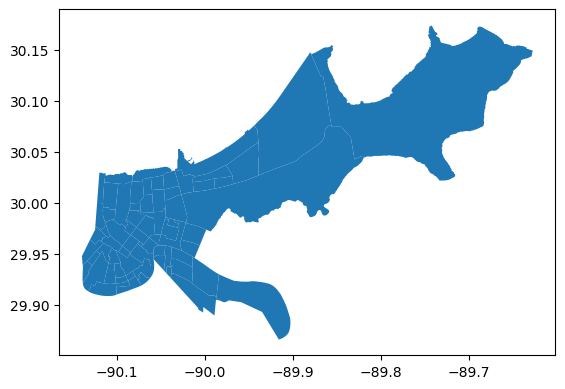

In [4]:
neighborhoodsDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson")
neighborhoodsDf.plot()

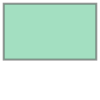

In [5]:
nolaBoundBox = shapely.box(*neighborhoodsDf.total_bounds)
nolaBoundBox

In [6]:
lp(f"New Orleans boundary:  {neighborhoodsDf.total_bounds}")

[2025-03-24 13:54:11.195348] New Orleans boundary:  [-90.14003674  29.8656102  -89.62778614  30.17481061]


In [7]:
tileIndex = gpd.read_file(f"{dataPath}USGS_LA_2021GNO_1_C22_TileIndex{os.sep}USGS_LA_2021GNO_1_C22_TileIndex.shp").to_crs(neighborhoodsDf.crs)
tileIndex.head()

,Name,Comment,PRJ_ID,WU_ID,WU_Name,geometry
0,w0809n3329,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((-89.78496 30.05285, -89.79532 30.053..."
1,w0755n3296,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((-90.35233 29.76785, -90.36267 29.768..."
2,w0673n3303,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((-91.19885 29.84526, -91.20403 29.845..."
3,w0704n3295,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((-90.87965 29.76834, -90.88999 29.768..."
4,w0748n3320,None,300052,300052,LA_2021GNO_1_C22,"POLYGON ((-90.4191 29.98566, -90.42946 29.9858..."


In [8]:
nolaTileMask = tileIndex.intersects(nolaBoundBox)
lp(f"{np.count_nonzero(nolaTileMask)} files found")

[2025-03-24 13:54:11.290946] 833 files found


<Axes: >

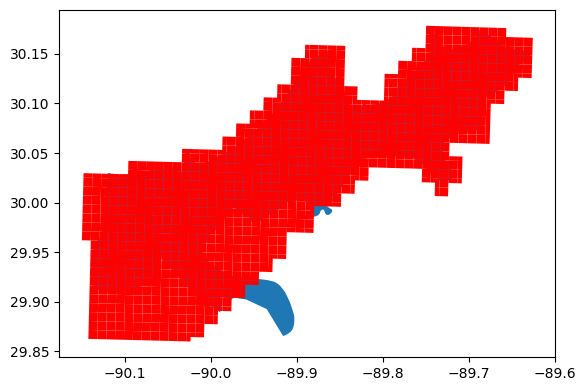

In [9]:
ax = neighborhoodsDf.plot()
tileIndex[nolaTileMask].plot(color='red', ax=ax)

In [10]:
lazPath = f'{dataPath}laz{os.sep}'

In [11]:
lidarS3Keys = tileIndex.loc[nolaTileMask,'Name'].map(lambda name: (f"Projects/LA_2021GreaterNewOrleans_C22/LA_2021GNO_1_C22/LAZ/USGS_LPC_LA_2021GreaterNewOrleans_C22_{name}.laz", f"{lazPath}USGS_LPC_LA_2021GreaterNewOrleans_C22_{name}.laz")).to_list()
lidarS3Keys[:5]

[('Projects/LA_2021GreaterNewOrleans_C22/LA_2021GNO_1_C22/LAZ/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0809n3329.laz',
  './datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0809n3329.laz'),
 ('Projects/LA_2021GreaterNewOrleans_C22/LA_2021GNO_1_C22/LAZ/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0798n3329.laz',
  './datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0798n3329.laz'),
 ('Projects/LA_2021GreaterNewOrleans_C22/LA_2021GNO_1_C22/LAZ/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0799n3326.laz',
  './datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0799n3326.laz'),
 ('Projects/LA_2021GreaterNewOrleans_C22/LA_2021GNO_1_C22/LAZ/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0813n3329.laz',
  './datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0813n3329.laz'),
 ('Projects/LA_2021GreaterNewOrleans_C22/LA_2021GNO_1_C22/LAZ/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0797n3332.laz',
  './datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0797n3332.laz')]

In [12]:
lp(f"Checking for {lazPath}")
if not os.path.exists(lazPath):
    lp(f"Creating LAZ path {lazPath}")
    os.makedirs(lazPath)


[2025-03-24 13:54:11.545262] Checking for ./datasets/laz/


In [ ]:
startTime = datetime.now()
filesDownloaded = 0
s3Client = boto3.client('s3')
for idx, key in enumerate(lidarS3Keys):
    if os.path.exists(key[1]):
        lp(f"{key[1]} already exists skipping [{idx}]!")
        continue

        
    lp(f"Downloading{idx} {key[1]}")
    with open(key[1], 'wb') as f:
        s3Client.download_fileobj('usgs-lidar', key[0], f, ExtraArgs={'RequestPayer':'requester'})

    filesDownloaded += 1

lp(f"{filesDownloaded} files downloaded in {datetime.now() - startTime}")



[2025-03-24 13:54:11.705516] Downloading0 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0809n3329.laz
[2025-03-24 13:54:16.169491] Downloading1 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0798n3329.laz
[2025-03-24 13:54:22.599423] Downloading2 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0799n3326.laz
[2025-03-24 13:54:32.757523] Downloading3 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0813n3329.laz
[2025-03-24 13:54:35.427043] Downloading4 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0797n3332.laz
[2025-03-24 13:54:47.213743] Downloading5 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0800n3340.laz
[2025-03-24 13:54:47.444977] Downloading6 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0801n3325.laz
[2025-03-24 13:54:50.803559] Downloading7 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0822n3340.laz
[2025-03-24 13:54:52.759612] Downloading8 ./datasets/laz/USGS_LPC_LA_2021GreaterNewOrleans_C22_w0778n3309.laz


In [ ]:
lp("Done!")